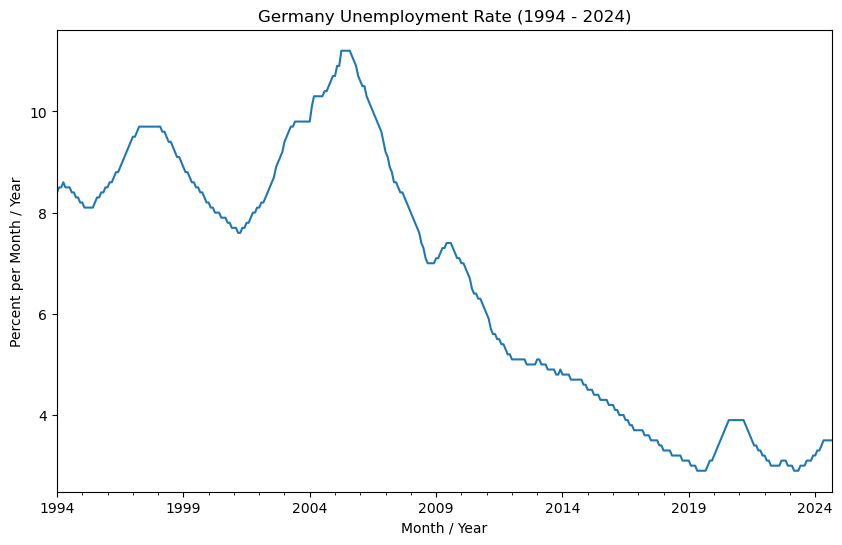

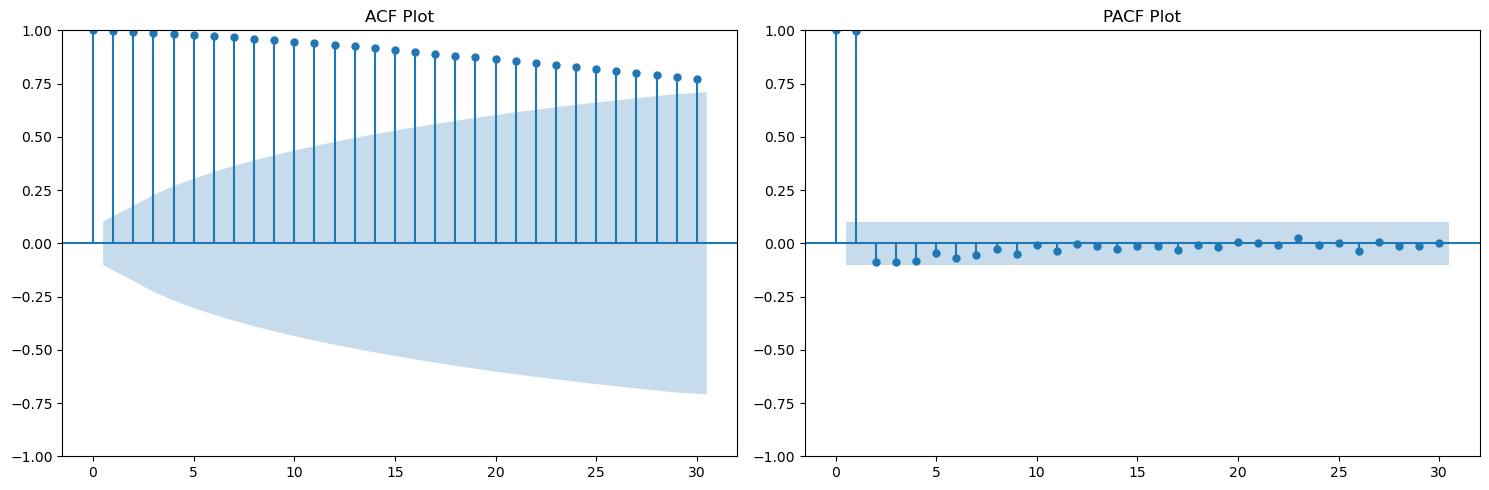

ARIMA(0, 0, 0) - AIC: 1966.50
ARIMA(0, 0, 1) - AIC: 1541.95
ARIMA(0, 0, 2) - AIC: 1154.90
ARIMA(0, 0, 3) - AIC: 825.23
ARIMA(0, 1, 0) - AIC: -674.21
ARIMA(0, 1, 1) - AIC: -709.70
ARIMA(0, 1, 2) - AIC: -756.42
ARIMA(0, 1, 3) - AIC: -787.46
ARIMA(1, 0, 0) - AIC: -665.13
ARIMA(1, 0, 1) - AIC: -700.62
ARIMA(1, 0, 2) - AIC: -747.35
ARIMA(1, 0, 3) - AIC: -778.42
ARIMA(1, 1, 0) - AIC: -744.53
ARIMA(1, 1, 1) - AIC: -820.90
ARIMA(1, 1, 2) - AIC: -838.65
ARIMA(1, 1, 3) - AIC: -836.90
ARIMA(2, 0, 0) - AIC: -735.49
ARIMA(2, 0, 1) - AIC: -659.13
ARIMA(2, 0, 2) - AIC: -829.05
ARIMA(2, 0, 3) - AIC: -826.87
ARIMA(2, 1, 0) - AIC: -818.20
ARIMA(2, 1, 1) - AIC: -837.00
ARIMA(2, 1, 2) - AIC: -836.85
ARIMA(2, 1, 3) - AIC: -835.62
ARIMA(3, 0, 0) - AIC: -809.28
ARIMA(3, 0, 1) - AIC: -826.32
ARIMA(3, 0, 2) - AIC: -827.47
ARIMA(3, 0, 3) - AIC: -703.48
ARIMA(3, 1, 0) - AIC: -836.39
ARIMA(3, 1, 1) - AIC: -836.45
ARIMA(3, 1, 2) - AIC: -834.23
ARIMA(3, 1, 3) - AIC: -834.37

Best ARIMA Model:
Order: (1, 1, 2), AIC:

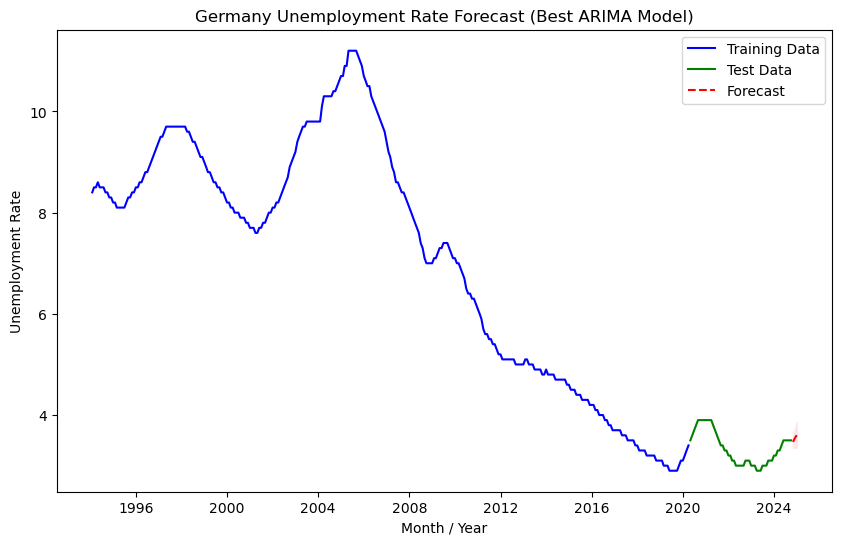

In [1]:
import os
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

new_directory = 'C:/Users/artem/Desktop'

os.chdir(new_directory)

#Data from German Federal Statistical Office (Downloaded on 15/11/2024)

#Available at: https://www-genesis.destatis.de/datenbank/online/statistic/13231/table/13231-0001

#We follow X13 Demetra+ trend (in % from January 1994 to September 2024)

unemployment = pd.read_csv('13231-0001_en.csv', decimal='.')

unemployment.rename(columns={'Unemployment rate': 'Unemployment Rate'}, inplace=True)

dates = pd.date_range(start='1994', periods=len(unemployment), freq='M')
unemployment.index = dates 

plt.figure(figsize=(10, 6))
unemployment['Unemployment Rate'].plot()
plt.title('Germany Unemployment Rate (1994 - 2024)')
plt.xlabel('Month / Year')
plt.ylabel('Percent per Month / Year')
plt.show()

def acf_pacf_fig(series, both=True, lag=30):
    fig, axes = plt.subplots(1, 2 if both else 1, figsize=(15, 5))
    
    if both:
        plot_acf(series, lags=lag, ax=axes[0])
        plot_pacf(series, lags=lag, ax=axes[1])
        axes[0].set_title('ACF Plot')
        axes[1].set_title('PACF Plot')
    else:
        plot_acf(series, lags=lag, ax=axes[0])
        axes[0].set_title('ACF Plot')
    
    plt.tight_layout() 
    plt.show()

acf_pacf_fig(unemployment['Unemployment Rate'], both=True, lag=30)

train_size = 315 
train = unemployment[:train_size].copy()
test = unemployment[train_size:].copy()

best_aic = float('inf')
best_order = None
best_model = None

#We supress future warnings related to ARIMA model selection
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to ")

for p in range(0, 4):  
    for d in range(0, 2):  
        for q in range(0, 4):  
            try:
                model = ARIMA(train['Unemployment Rate'], order=(p, d, q), trend='t').fit()
                print(f"ARIMA({p}, {d}, {q}) - AIC: {model.aic:.2f}")

                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, d, q)
                    best_model = model
            except Exception as e:
                print(f"ARIMA({p}, {d}, {q}) failed to fit: {e}")

print("\nBest ARIMA Model:")
print(f"Order: {best_order}, AIC: {best_aic:.2f}")
print(best_model.summary())

residuals = best_model.resid
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nLjung-Box test for residuals:\n", lb_test)

forecast_periods = 3 
forecast = best_model.get_forecast(steps=forecast_periods)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_dates = pd.date_range(start='2024-10-31', periods=forecast_periods, freq='M')
forecast_series = pd.Series(forecast_values.values, index=forecast_dates)
print("\nForecast for Oct 2024, Nov 2024, and Dec 2024:")
print(forecast_series)

plt.figure(figsize=(10, 6))
plt.plot(unemployment.index[:train_size], train['Unemployment Rate'], label='Training Data', color='blue')
plt.plot(unemployment.index[train_size:], test['Unemployment Rate'], label='Test Data', color='green')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red', linestyle='--')
plt.fill_between(forecast_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Germany Unemployment Rate Forecast (Best ARIMA Model)")
plt.xlabel('Month / Year')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()

Author: Artem Urlapov Sedova (Universidad Autónoma de Madrid)